In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import torch
from torch.utils.data import DataLoader
import os
import numpy as np
from PIL import Image

from utils.loss import LOSS_FN, LOSS_EVAL
from utils.model import SegDataset, UNet
from utils.utils import load_model, read_raster

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


In [2]:

device = "cpu"

# Zurich
train_images = ["./data/zurich_mask.tif", "./data/zurich.tif", "./data/zurich_terrain.tif"]
mask_images  = ["./data/zurich_svf_masked.tif"]

# Singapore
train_images = ["./data/sg_mask.tif", "./data/sg.tif", "./data/sg_terrain.tif"]
mask_images  = ["./data/sg_svf_masked.tif"]                                    

train_rasters = []
mask_rasters  = []
for file in train_images:
    data, _, _, _ = read_raster(file)
    if file.endswith('_terrain.tif'):
        minval = np.min(data)
        data = data - minval
    train_rasters.append(torch.tensor(data, device=device, dtype=torch.float32))
for file in mask_images:
    data, _, _, _ = read_raster(file)
    mask_rasters.append(torch.tensor(data, device=device))
data_shape = data.shape


In [3]:
model = None
prev_losses = None

def loadModel():
    global prev_losses
    filename = 'models/model_SVF.100.pth'
    current_epoch = 100
    MODEL_LOADED = None
    if filename is not None:
        loaded = load_model(filename, UNet, strict=True, load_ema=True, in_channels=len(train_rasters))
        model = loaded["model"].to(device)
        prev_losses = loaded["prev_losses"]
        print('Model loaded:', filename)
    return model, current_epoch, MODEL_LOADED

model, _,_ =loadModel()

Model loaded: models/model_SVF.100.pth


location: [5315, 3516]
loss: 0.00012699857037507355 0.005392816470085215, diff sum: 540.119006451831
eval - MAE:0.008242, MSE: 0.000127


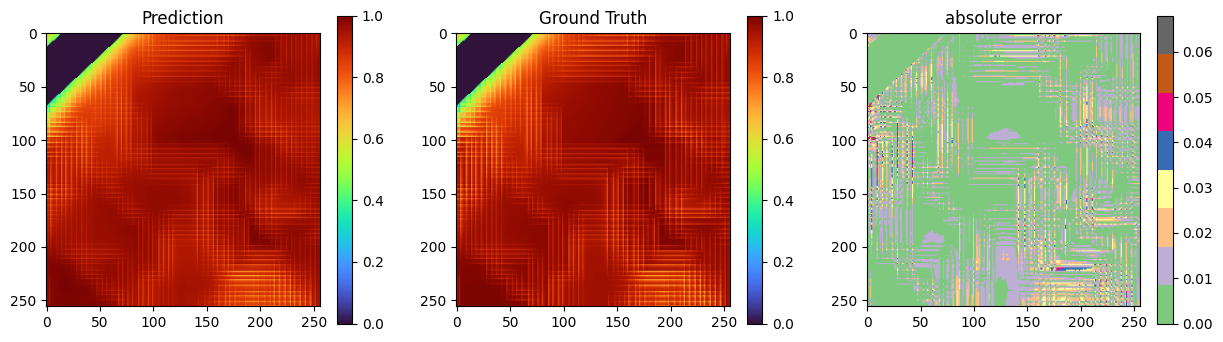

location: [2695, 7349]
loss: 0.00552379116499973 0.005392816470085215, diff sum: 2030.178687109404
eval - MAE:0.030978, MSE: 0.005524


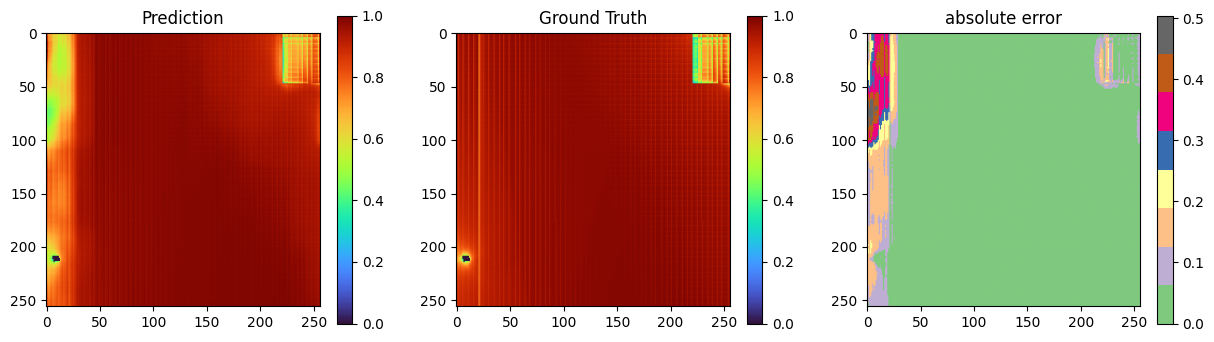

location: [3272, 8757]
loss: 0.00010937704456903606 0.005392816470085215, diff sum: 540.5035459016623
eval - MAE:0.008247, MSE: 0.000109


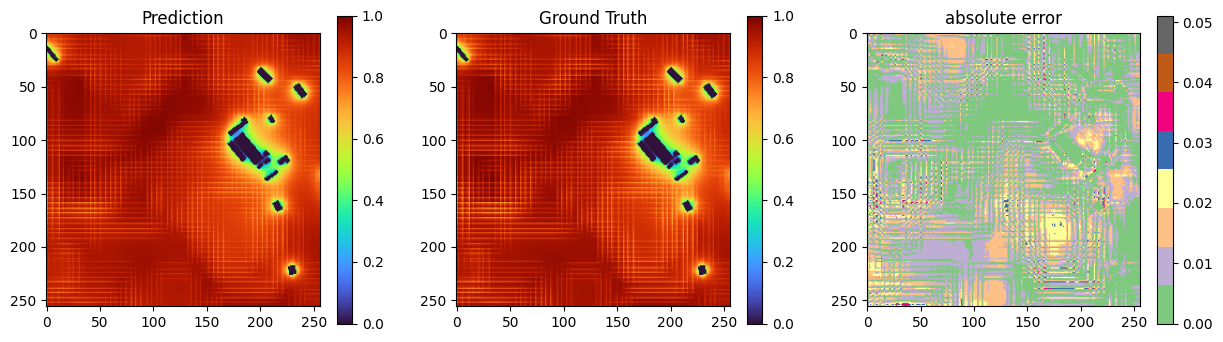

location: [5872, 2397]
loss: 0.004227776332490216 0.005392816470085215, diff sum: 1454.5685060824167
eval - MAE:0.022195, MSE: 0.003512


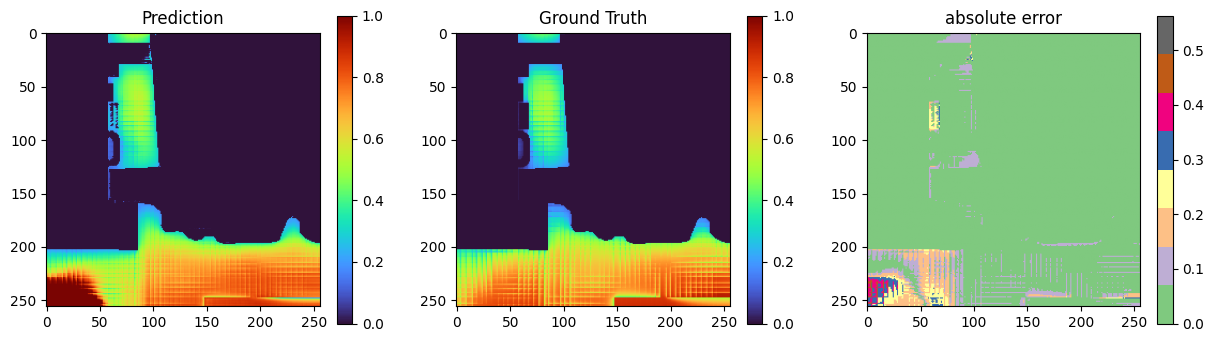

In [7]:


idx = []
datalen = 4
batch_size = 8
scan = 128
size = 512
footprint_raster = train_rasters[0]
while len(idx) < max(datalen, batch_size):
    y, x = random.randint(0, data_shape[0] - 512 - 1), random.randint(0, data_shape[1] - 512 - 1)
    if footprint_raster[y : y+size, x : x+size].sum() > 0:
        idx.append([y, x])
dataset = SegDataset(train_rasters, mask_rasters, idx, size=512, offset=[0, 0], terrain_idx=-1)
val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model.eval()
with torch.no_grad():
    for step, batch in enumerate(val_loader):
        imgs, masks = batch[0].to(device), batch[1].to(device)
        logits = model(imgs)
        loss = LOSS_FN(logits, imgs, masks)
        for j in range(datalen):
            # pred = (logits[j,0] * (1 - imgs[j,0])).clamp(0, 1).cpu().numpy() 
            pred = (logits[j,0]).clamp(0, 1).cpu().numpy() 
            # pred = torch.sigmoid(logits[j,0]).cpu().numpy() 
            pred  = pred[scan : -scan, scan : -scan]
            true = masks[j,0].cpu().numpy()
            true = true[scan : -scan, scan : -scan]

            valmin = np.min([pred, true])
            diff = np.abs(pred - true)
            diffmax = np.max(diff)
            val = [{
                'label': 'Prediction',
                'v': pred,
                "color": 'turbo',
                'vminmax': [valmin, 1]
            }, { 
                'label': 'Ground Truth',
                'v': true,
                "color": 'turbo',
                'vminmax': [valmin, 1]
            }, {
                'label': f'absolute error',
                'v': diff,
                "color": 'Accent',
                # 'vminmax': [0, np.min([0.05, diffmax])]
                'vminmax': [0, diffmax]
                # 'vminmax': [None, None]
            # }, {
            #     'label': 'mask',
            #     'v': img[0].cpu().numpy()[scan : -scan, scan : -scan],
            #     "color": None,
            #     # 'vminmax': [0, 0.2]
            #     'vminmax': [0, 1]
            }]
            fig, ax = plt.subplots(1, len(val))
            
            fig.set_figheight(4)
            fig.set_figwidth(15)

            for i in range(len(val)):
                vmin, vmax = val[i]['vminmax']
                im = ax[i].imshow(val[i]['v'], val[i]['color'], vmin=vmin, vmax=vmax)
                ax[i].set_title(val[i]['label'])

                plt.colorbar(im)


            lss = LOSS_FN(logits[j:j+1], imgs[j:j+1], masks[j:j+1])
            lss_eval = LOSS_EVAL(logits[j:j+1], imgs[j:j+1], masks[j:j+1])
            print(f'location: {idx[j]}')
            print(f'loss: {lss} {loss}, diff sum: {diff.sum()}')
            print(f'eval - {lss_eval}')
            plt.show()


train loss [0.004001607018745876, 0.0004565702719154124, 0.0002784814670745385, 0.00023237290404506665, 0.00021413370163605089, 0.00020674897189808171, 0.00018587247536984569, 0.00019025737906062796, 0.00016500062555035988, 0.00015196208330784766, 0.00016706780080742123, 0.00012823951293146888, 0.0001425538459531503, 0.0001671115326584589, 0.0001045394292780271, 0.00012466125882978782, 7.862919003048212e-05, 0.00011199561457527292, 8.075171512327406e-05, 6.697939737919507e-05, 5.6507690116833735e-05, 4.9789172153116876e-05, 4.745327900326857e-05, 4.5443060915906344e-05, 4.3072194373131757e-05, 4.017110623956812e-05, 3.577469507396911e-05, 3.668128932953138e-05, 3.1894359512071456e-05, 3.2961074352977854e-05, 3.3816135648737376e-05, 2.9521658401484138e-05, 2.7099559965374412e-05, 3.0753773525930465e-05, 2.4537467194111572e-05, 2.395147407353569e-05, 2.5432014901831708e-05, 2.165839199698911e-05, 2.2988889641663784e-05, 2.5700792887841105e-05, 3.5713648217549124e-05, 2.4492093922337032e-

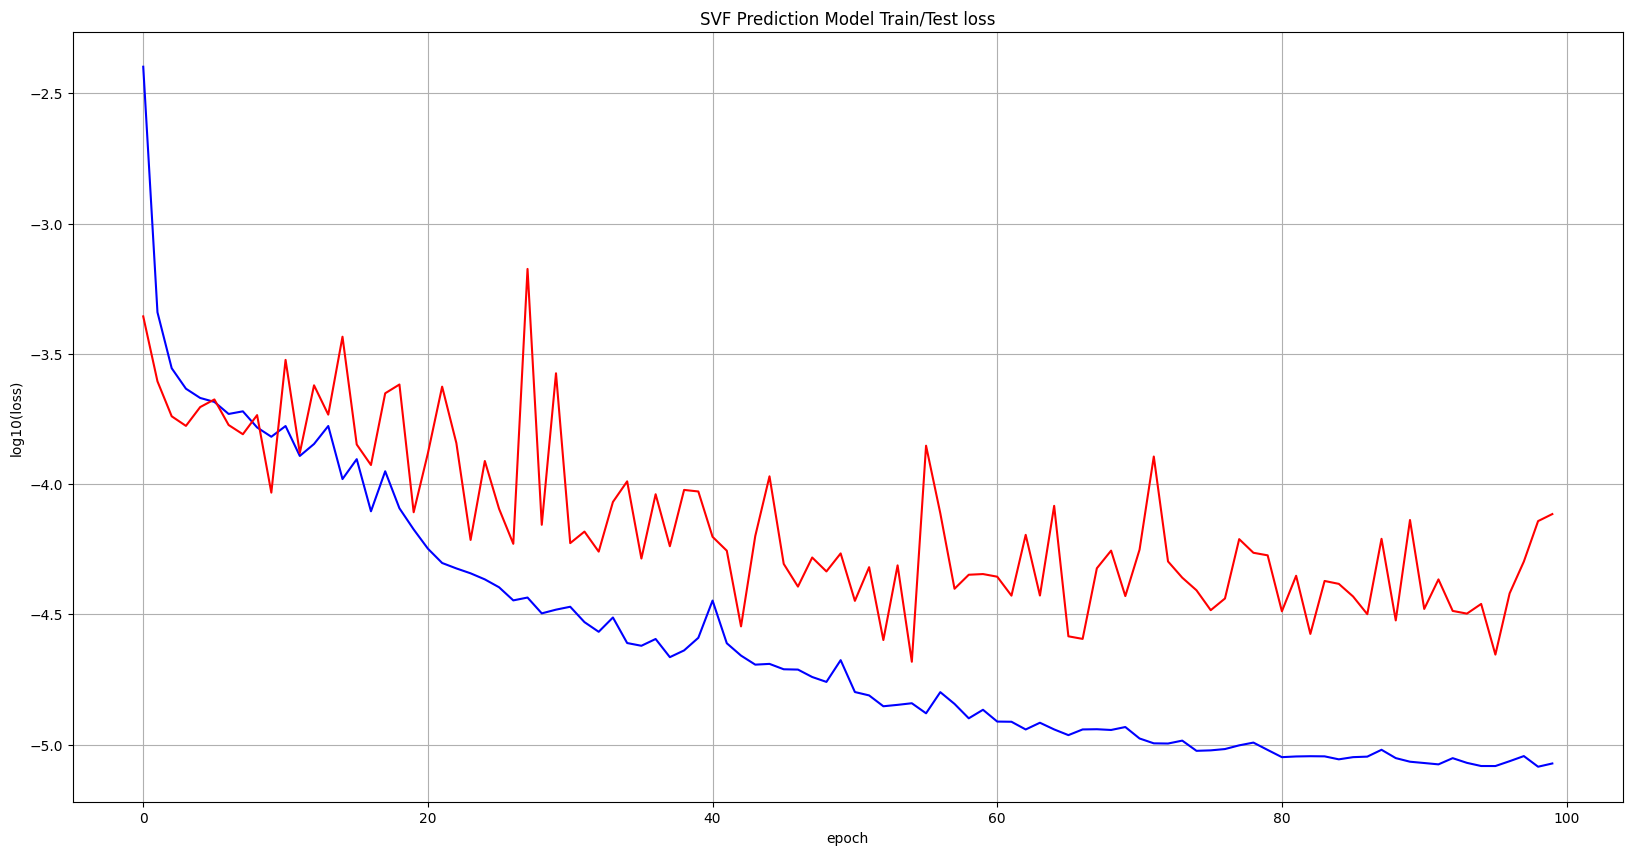

In [8]:

if prev_losses:
    l_t = (prev_losses[0].copy())
    l_v = np.clip(prev_losses[1], 0, 0.5)
    l_v = prev_losses[1].copy()
    print('train loss', l_t)
    print('test lost',l_v)
    l_t_log = np.log10(l_t)
    l_v_log = np.log10(l_v)
    # l_t[0] = None
    # l_v[0] = None
    # print(l_t)
    # print(l_v)

    # plt.plot(l_t, c='b')
    # plt.plot(l_v, c='r')
    # plt.xticks([i for i in range(len(l_v))], [f'{i+1}' for i in range(len(l_v))])
    # plt.xlabel('epoch')
    # plt.ylabel('loss')
    # plt.ylim(0, np.max([l_t[1:], l_v[1:]]) * 1.1)
    # plt.rcParams["figure.figsize"] = (20,3)

    # plt.show()
    plt.plot(l_t_log, c='b')
    plt.plot(l_v_log, c='r')
    # plt.xticks([i for i in range(0, epochs + 1, 5)], [f'{i}' for i in range(0, epochs + 1, 5)])
    # plt.xticks([i for i in range(0, len(l_v), 5)], [f'{i+1}' for i in range(0, len(l_v), 5)])
    # plt.xticks([i for i in range(len(l_v))], [f'{i+1}' for i in range(len(l_v))])
    plt.title('SVF Prediction Model Train/Test loss')
    plt.xlabel('epoch')
    plt.ylabel('log10(loss)')
    plt.grid(True)
    # plt.ylim(None, np.max([l_t[1:], l_v[1:]]) * 1.1)
    plt.rcParams["figure.figsize"] = (20,10)

    plt.show()